In [2]:
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from pathlib import Path
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# 解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams["axes.unicode_minus"]=False 

c:\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data=pd.read_csv('./try.csv')
train_data,test_data=train_test_split(data,test_size=0.2, random_state=1318)
feature=train_data.drop(['Ea','Unnamed: 0'],axis=1)
label=train_data['Ea']
x_test=test_data.drop(['Ea','Unnamed: 0'],axis=1)
y_test=test_data['Ea']

In [4]:
kfold = KFold(n_splits = 5, random_state = 1314, shuffle = True)

In [5]:
def optuna_objective(trial):
    iterations=trial.suggest_int('iterations',100,1000,10)
    max_depth=trial.suggest_int("max_depth",2,15,1)
    l2_leaf_reg=trial.suggest_float("l2_leaf_reg",1,4)
    learning_rate=trial.suggest_float("learning_rate",0.05,0.3)
    reg=cb.CatBoostRegressor(iterations=iterations,
                             max_depth=max_depth,
                             l2_leaf_reg=l2_leaf_reg,
                             learning_rate=learning_rate,
                             silent=True
                             )
    loss=cross_val_score(reg,feature,label,cv=kfold,error_score='raise')
    return pow(abs(loss.mean()),0.5)

In [6]:
def optimizer_optuna(n_trials):
    algo=optuna.samplers.TPESampler(n_startup_trials=10,n_ei_candidates=24)
    study=optuna.create_study(sampler=algo,direction="maximize")
    study.optimize(optuna_objective,n_trials=n_trials,show_progress_bar=True)
    print("\n","\n","best params: ", study.best_trial.params,
          "\n","\n","best score: ", study.best_trial.values,
          "\n")
    
    return study.best_trial.params, study.best_trial.values

In [7]:
optimizer_optuna(10)

[I 2023-07-11 22:42:46,722] A new study created in memory with name: no-name-75ed2cf4-b6c2-40a2-8401-6f46f709ea52
Best trial: 0. Best value: 0.868159:  10%|█         | 1/10 [00:04<00:43,  4.78s/it]

[I 2023-07-11 22:42:51,503] Trial 0 finished with value: 0.8681593673781737 and parameters: {'iterations': 600, 'max_depth': 8, 'l2_leaf_reg': 3.6149049315727084, 'learning_rate': 0.1622644718245384}. Best is trial 0 with value: 0.8681593673781737.


Best trial: 0. Best value: 0.868159:  10%|█         | 1/10 [02:31<22:44, 151.65s/it]


[W 2023-07-11 22:45:18,309] Trial 1 failed with parameters: {'iterations': 710, 'max_depth': 15, 'l2_leaf_reg': 2.992688674007388, 'learning_rate': 0.21909023087632473} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "c:\anaconda3\envs\pytorch\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Dell\AppData\Local\Temp\ipykernel_2508\2306277150.py", line 12, in optuna_objective
    loss=cross_val_score(reg,feature,label,cv=kfold,error_score='raise')
  File "c:\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py", line 515, in cross_val_score
    cv_results = cross_validate(
  File "c:\anaconda3\envs\pytorch\lib\site-packages\sklearn\model_selection\_validation.py", line 266, in cross_validate
    results = parallel(
  File "c:\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\parallel.py", line 63, in __call__
    return super().__call__(

KeyboardInterrupt: 

In [8]:
model = cb.CatBoostRegressor(iterations=48,max_depth=4,l2_leaf_reg=2.06000375317057346,silent=True,
                             random_state=1316,learning_rate=0.11000509544289725).fit(X=feature , y=label)
r2_score = cross_val_score(model, feature, label, cv=kfold, scoring='r2').mean()
rmse_score = pow(abs(cross_val_score(model, feature, label, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5)
print('r2:',r2_score)
print('rmse:',rmse_score)

r2: 0.7467145285685243
rmse: 0.1543118559018476


In [9]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
print('r2:',r2_score(label,model.predict(feature)))
print('MAE:',mean_absolute_error(label,model.predict(feature)))
print('测试集得分为：', r2_score(y_test,model.predict(x_test)),mean_absolute_error(y_test,model.predict(x_test)))

r2: 0.8968222820737524
MAE: 0.08586822837459228
测试集得分为： 0.850889252411177 0.0929342527167225


In [10]:
# 预测1
Y1=model.predict(test_data.drop(['Ea','Unnamed: 0'],axis=1))
Y2=test_data['Ea']
d={'Y_pred':Y1,
   'Y_True':Y2
   }
pred_show=pd.DataFrame(d)

In [11]:
# 预测2
Y_1=model.predict(feature)
Y_2=label
d_1={'Y_pred':Y_1,
   'Y_True':Y_2
   }
pred_show_1=pd.DataFrame(d_1)

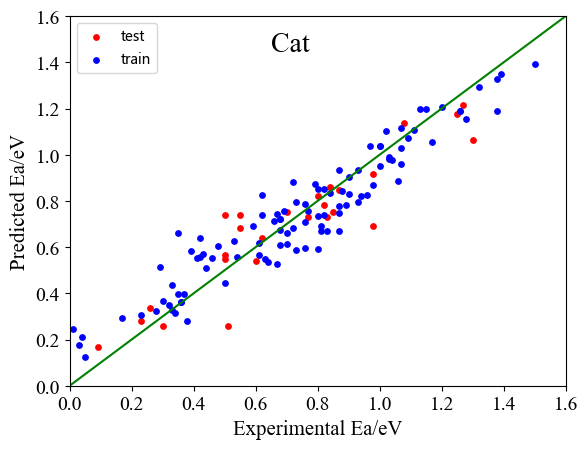

In [12]:
plt.scatter(pred_show.iloc[:,1],pred_show.iloc[:,0],color='r',s=15,label='test')
plt.scatter(pred_show_1.iloc[:,1],pred_show_1.iloc[:,0],color='b',s=15,label='train')
plt.xlim((0,1.6))
plt.xlabel('Experimental Ea/eV',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.xticks(fontsize=14,fontname='Times New Roman')
plt.ylim((0,1.6))
plt.ylabel('Predicted Ea/eV',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.yticks(fontsize=14,fontname='Times New Roman')
plt.plot([0,1.6],[0,1.6],color='g')
plt.text(0.65,1.45,'Cat',fontsize=20,font=Path('..\TimesNewRoman.ttf'))
plt.legend()
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


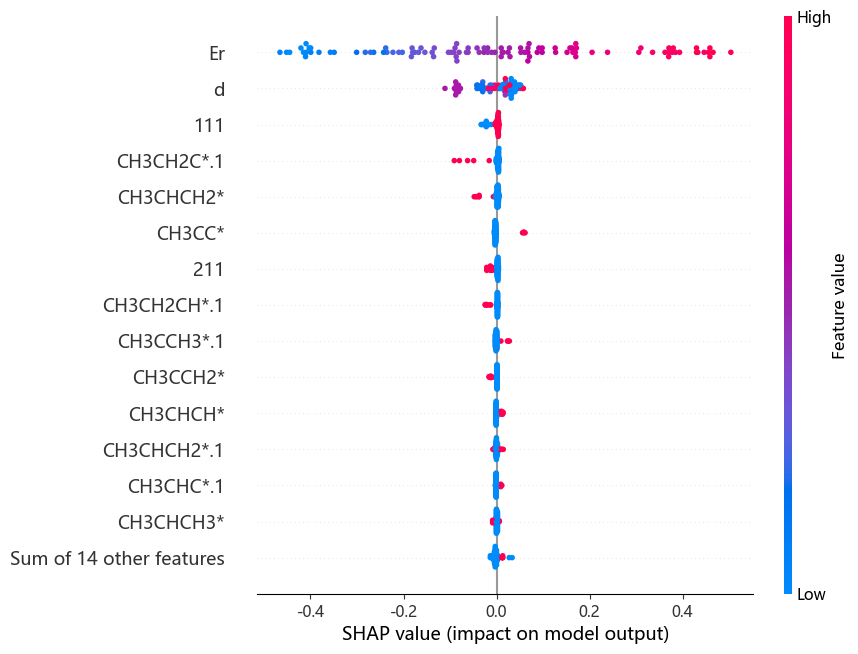

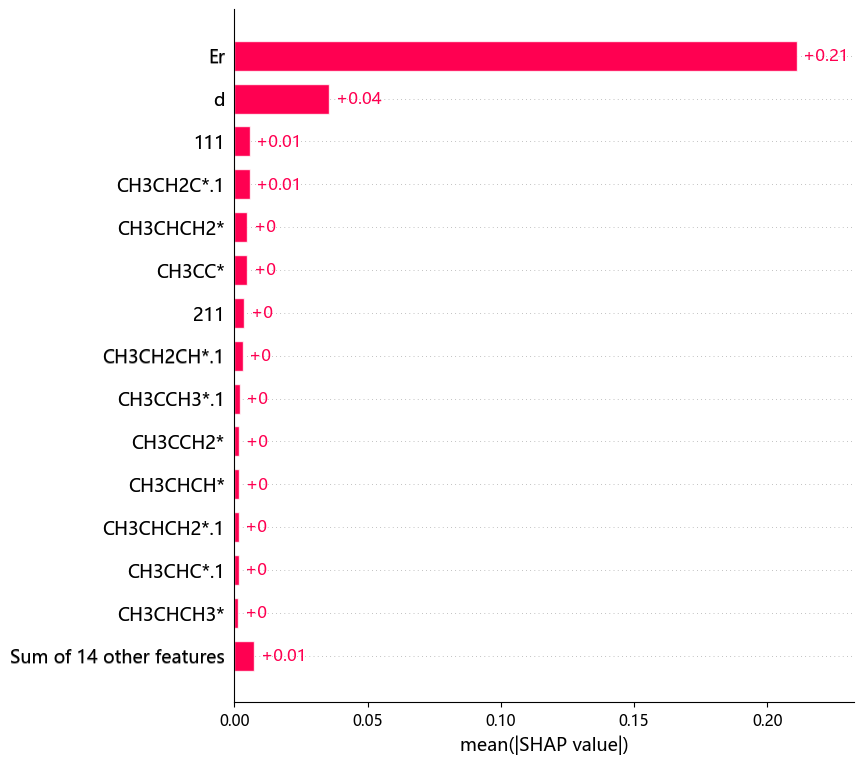

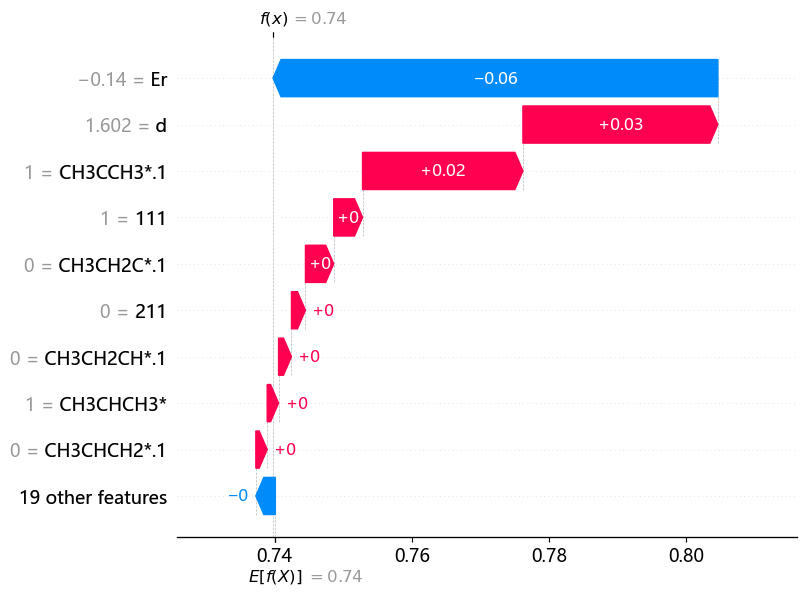

In [13]:

# shap提高解释性
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer(feature)
shap.plots.beeswarm(shap_values, max_display=15)
shap.plots.bar(shap_values, max_display=15)
shap.plots.waterfall(shap_values[10], max_display=10)
shap.plots.force(shap_values[5])
shap.force_plot(explainer.expected_value, shap_values.values, feature)